In [4]:
using CairoMakie
using FourierFlows
using JLD2
using Printf
using StatsBase
include("../AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
function find_max_u(directory)
    params = read_swqg_params(directory, "swqg")
    nx, Lx = get_grid_size(directory, "swqg")
    grid = TwoDGrid(; nx, Lx)
    
    filename_func(idx) = @sprintf("%s/swqg.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("swqg.", file)])-1
    file_idx = 1
    ψh = zeros(Complex{Float64}, grid.nkr, grid.nl, 2)

    umax = 0
    max_index = 0
    max_time = 0
    cur_idx = 2
    for j=0:num_files
        file = jldopen(filename_func(j))
        for key=keys(file["snapshots/t"])[end-100:10:end]
            t = file["snapshots/t/" * key]
            qh = file["snapshots/sol/" * key]
            @. ψh = -qh/(grid.Krsq + params.Kd2)
            uh =  -grid.l  .* ψh
            vh =   grid.kr .* ψh
            u = irfft(uh, grid.nx)
            v = irfft(vh, grid.nx)
            max_speed = sqrt.(maximum(u.^2 + v.^2))
            if max_speed >= umax
                umax = max_speed
                max_index = cur_idx
                max_time = t
            end
            cur_idx += 1
        end
        close(file)
    end
    return umax, max_index, max_time
end

find_max_u (generic function with 1 method)

In [45]:
predicate = "/scratch/nad9961/swqg/"
froude_number = []
max_x_froude_number = []
max_xt_froude_number = []
max_ts = []
f0s = []
ωs = []
median_ωs = []
qs = []
for line=readlines("raytracing-runs.txt")
    run_directory = predicate * line
    f0, Cg = read_parameters(run_directory)
    nx, Lx = get_grid_size(run_directory, "swqg")
    grid = TwoDGrid(;nx, Lx)
    Nsnapshots = count_snapshots(run_directory)
    Nqg_snapshots = count_key_snapshots(run_directory, "swqg")
    t, _, k, up = load_snapshot(run_directory, Nsnapshots)
    t, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, Nqg_snapshots)
    rms_u = sqrt.(sum(u.^2 + v.^2) * (grid.dx * grid.dy) / grid.Lx/grid.Ly) * (grid.Lx/(2π))^2
    rms_up = sqrt.(sum(up[:,1].^2 + up[:,2].^2)/size(up, 1))
    rms_up = mean(sqrt.(up[:,1].^2 + up[:,2].^2))
    u_max_x = maximum(sqrt.(u.^2 + v.^2))
    #u_max_xt, max_index, max_time = find_max_u(run_directory)
    ω = compute_ω(k, f0, Cg)
    mean_ω = mean(ω[isfinite.(ω)])
    median_ω = median(ω[isfinite.(ω)])
    println(@sprintf("dir: %s, Umax_x: %0.4f, Urms: %0.4f Uprms: %0.4f, Cg: %0.2f, mean ω: %0.1f, Fr: %0.3f, Lx=%0.0fπ", line, u_max_x, rms_u, rms_up, Cg, mean_ω, rms_u/Cg, Lx/π))
    push!(max_x_froude_number, u_max_x / Cg)
    #push!(max_xt_froude_number, u_max_xt / Cg)
    push!(froude_number, rms_u / Cg)
    push!(ωs, mean_ω)
    push!(f0s, f0)
    push!(max_ts, t)
    push!(median_ωs, median_ω)
    push!(qs, q)
end

dir: 58025661/1, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0688, Cg: 0.40, mean ω: 109902.7, Fr: 0.266, Lx=2π
dir: 58025661/2, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0726, Cg: 0.42, mean ω: 319.7, Fr: 0.253, Lx=2π
dir: 58025661/3, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0914, Cg: 0.44, mean ω: 12.0, Fr: 0.242, Lx=2π
dir: 58025661/4, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0930, Cg: 0.46, mean ω: 8.7, Fr: 0.231, Lx=2π
dir: 58025661/5, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0879, Cg: 0.48, mean ω: 7.5, Fr: 0.222, Lx=2π
dir: 58025661/6, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0841, Cg: 0.50, mean ω: 6.5, Fr: 0.213, Lx=2π
dir: 58025661/7, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0819, Cg: 0.52, mean ω: 5.9, Fr: 0.205, Lx=2π
dir: 58025661/8, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0773, Cg: 0.54, mean ω: 5.5, Fr: 0.197, Lx=2π
dir: 58025661/9, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0769, Cg: 0.56, mean ω: 5.3, Fr: 0.190, Lx=2π
dir: 58025661/10, Umax_x: 0.3764, Urms: 0.1064 Uprms: 0.0751, Cg: 0.58, mean ω: 5.0

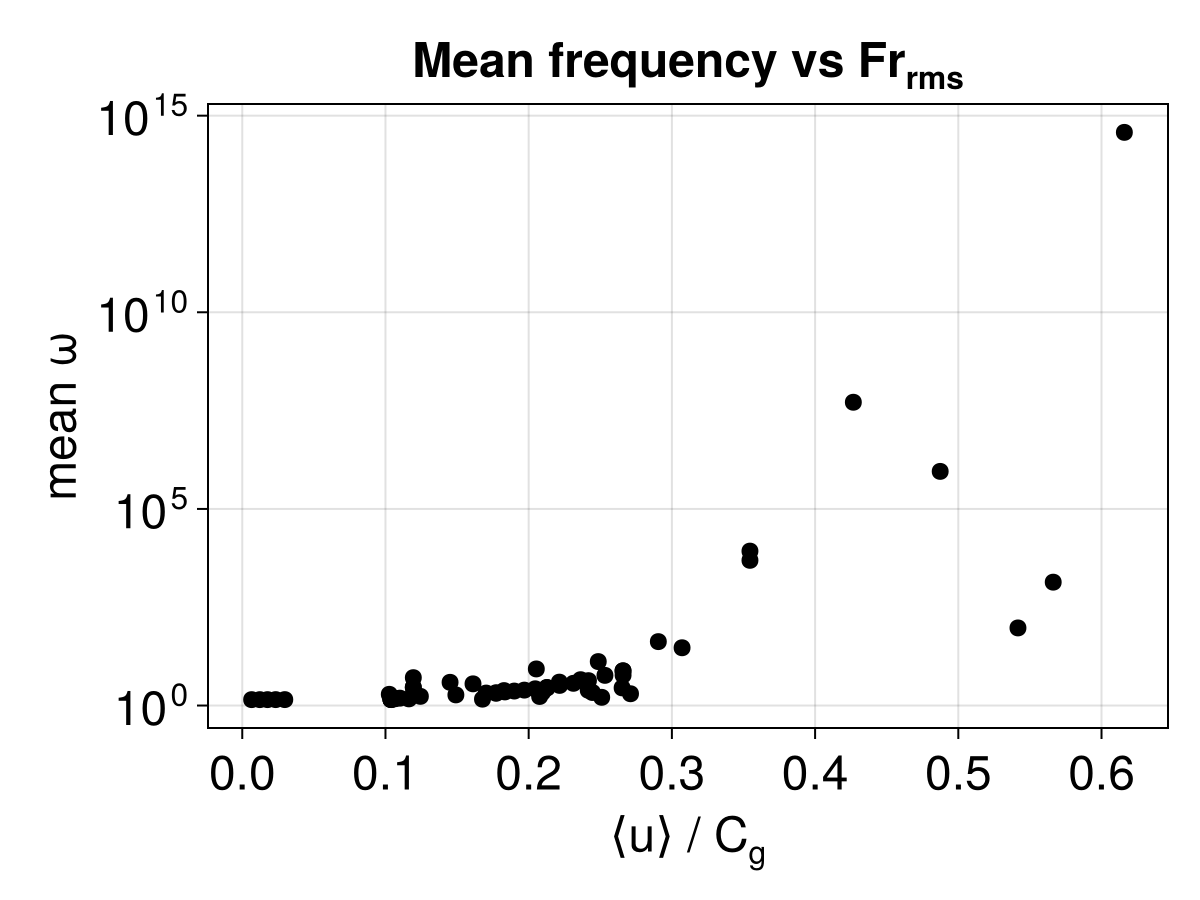

In [42]:
fig = Figure(fontsize=24)
ax = Axis(fig[1,1]; yscale=log10, xlabel=rich("⟨u⟩ / C",subscript("g")), ylabel=rich("mean ω"), title=rich("Mean frequency vs Fr", subscript("rms")))
scatter!(ax, froude_number, median_ωs./f0s, markersize=12, color=:black)
#scatter!(ax, froude_number, ωs./f0s, markersize=12, color=:red)

fig

In [10]:
fig = Figure(fontsize=24)
ax = Axis(fig[1,1]; yscale=log10, xlabel=rich("max", subscript("x,t"), "|u| / C",subscript("g")), ylabel=rich("mean ω"), title=rich("Mean frequency vs Fr", subscript("max")))
scatter!(ax, max_froude_number, median_ωs, markersize=12, color=:black)

fig

LoadError: UndefVarError: `max_froude_number` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

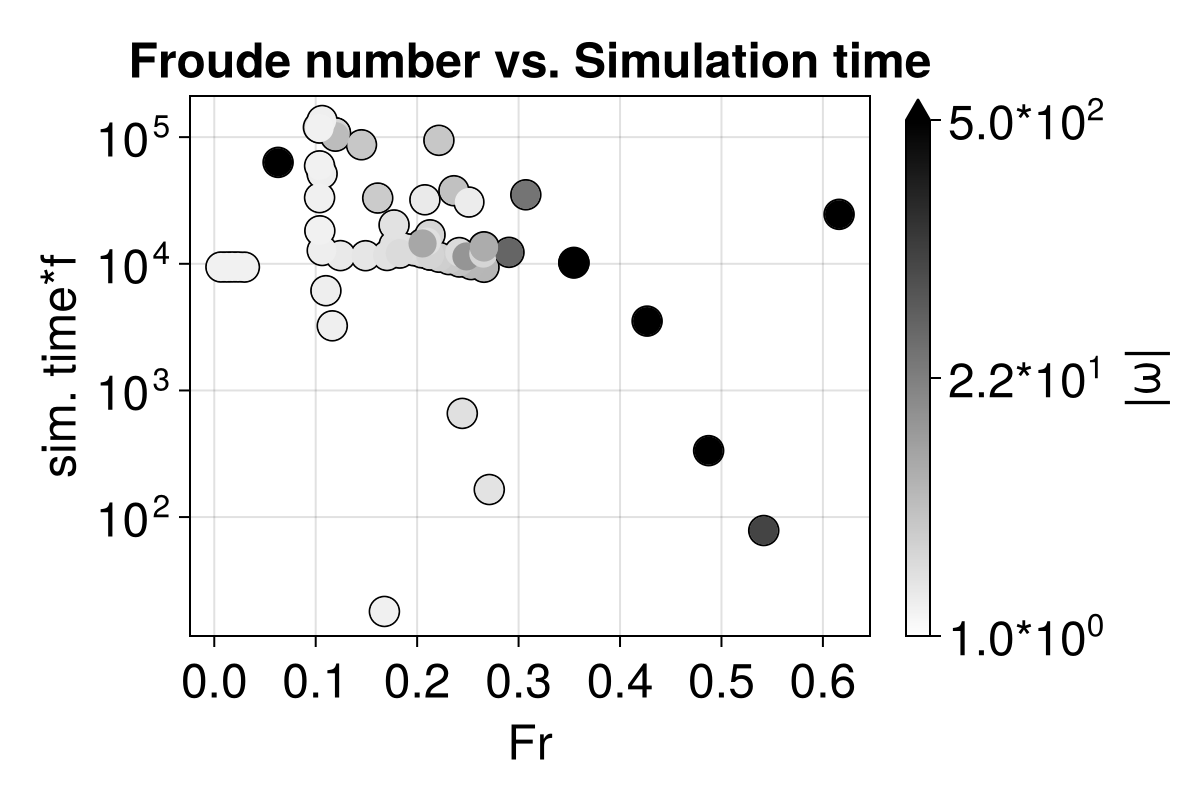

In [11]:
function to_scientific(val)
    power = floor(Int, log10.(val))
    mantissa = val / 10^power
    return rich(@sprintf("%0.1f*10", mantissa), superscript(@sprintf("%d", power)))
end

fig = Figure(size=(600, 400), fontsize=24)
ax = Axis(fig[1,1]; yscale=log10, xlabel="Fr", ylabel="sim. time*f", title="Froude number vs. Simulation time")
cutoff = 500
colors = 0.5*(log.(median_ωs./f0s)/log(cutoff)) .+ 0.5
tick_vals = [0.5, 0.75, 1.0]
tick_label_vals = exp.(2*(tick_vals .- 0.5)*log(cutoff))
tick_labels = [to_scientific(label_val) for label_val=tick_label_vals]
scatter!(ax, froude_number, max_ts.*f0s, markersize=21, color=:transparent, strokewidth=1, strokecolor=:black)
sc = scatter!(ax, froude_number, max_ts.*f0s, markersize=20, colorrange=(0.5, 1.0), highclip=:black, colormap=:binary, color=colors)
Colorbar(fig[1,2], sc; label="|ω|", ticks=(tick_vals, tick_labels))

fig

In [107]:
max_tsf0

Any[]

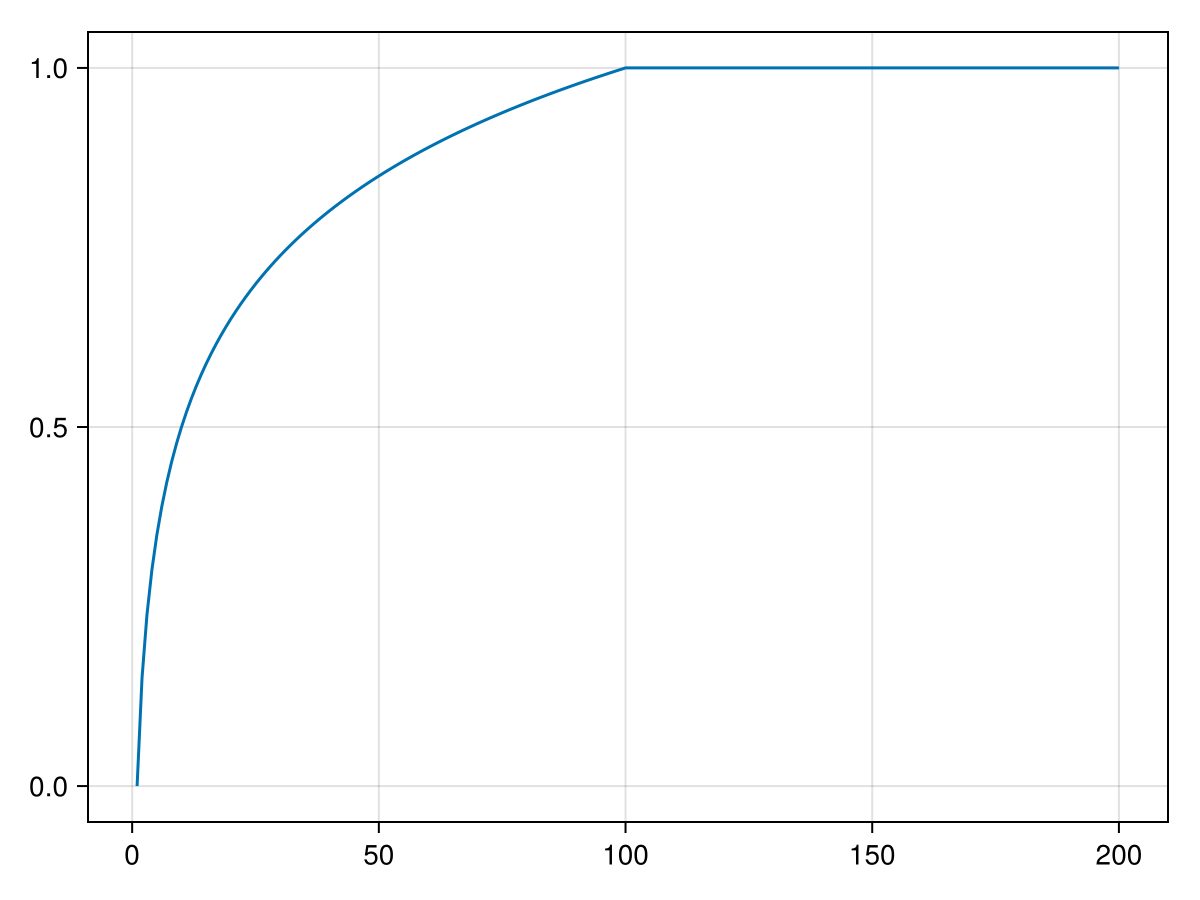

In [45]:
function color_gen(ω, cutoff)
    # If ω = 1: 0
    # If ω >= cutoff: 1
    # Logarithmic inbetween
    return log.(min.(ω, cutoff))/log(cutoff)
end

x = 1:200
cutoff = 100
lines(x, color_gen(x, cutoff))

In [36]:
color_gen(200, 200)

0.84122743555108

In [39]:
min.(1, log.(200/200))

0.0

In [29]:
weird_directory = "/scratch/nad9961/swqg/60202002/7/"
f0, Cg = read_parameters(weird_directory)
nx, Lx = get_grid_size(weird_directory, "swqg")
println(Lx)
grid = TwoDGrid(;nx, Lx)
t, q, ψ, u, v, Kd2 = load_qgsw_snapshot(weird_directory, grid, 3)
rms_vel = sqrt.(sum(u.^2 + v.^2)*grid.dx*grid.dy)
maximum(rms_vel / Cg)

18.849556


2.1028521064362735

In [31]:
median(sqrt.(u.^2 + v.^2))

0.09141794169705393

In [ ]:
grid =